### Question 1:  Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?

the company 'Enron' back in 2000 was known as one of the largest energy companies in the United States, with around $111 billion in revenues. At the end of 2001, it was revealed that there was widespread corporate fraud. Essentially all of Enron's nonexistent profits were created through a method called "mark-to-market" accounting, in which they would report profits even though they didn't earn a single dime. Even worse, they were solely responsible for the California electricity crisis, by which they performed large-scale blackouts to seize arbitrage opportunities.
###### The goal for this project is to analyze the characteristics of employees who worked at Enron during the crisis to  predict if they are a person of interest ("POI")
###### * this dataset contains 146 entries.
###### * there are some outliers in the data, i plotted the salaries and bonus data to have an illustration about the distribution of the data, then i calculated a vlaue (97.5 percentile) to compare its value with the field value and return if it has higher score, some outliers represent an executive level so i decided to keep them.


# data exploration

In [2]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")
import scipy
import pandas
import numpy
import matplotlib
import tester
from matplotlib import pyplot
from sklearn.feature_selection import SelectKBest
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from tester import test_classifier, dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary',
                 'bonus',
  'deferred_income',
  'director_fees',
  'exercised_stock_options',
  'expenses',
  'loan_advances',
  'long_term_incentive',
  'restricted_stock',
  'restricted_stock_deferred',
  'shared_receipt_with_poi',
  'total_payments',
  'total_stock_value',
'from_messages',
'from_poi_to_this_person',
  'from_this_person_to_poi',
    'to_messages'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
my_dataset = data_dict



##store the data in a data frame
df=pandas.DataFrame.from_dict(my_dataset, orient = 'index')

df= df[features_list]
df = df.replace('NaN', numpy.nan)
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 18 columns):
poi                          146 non-null bool
salary                       95 non-null float64
bonus                        82 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
shared_receipt_with_poi      86 non-null float64
total_payments               125 non-null float64
total_stock_value            126 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
to_messages                  86 non-null float

### Number of Null Values per feature

In [2]:
df.isnull().sum(axis=0) 


poi                            0
salary                        51
bonus                         64
deferred_income               97
director_fees                129
exercised_stock_options       44
expenses                      51
loan_advances                142
long_term_incentive           80
restricted_stock              36
restricted_stock_deferred    128
shared_receipt_with_poi       60
total_payments                21
total_stock_value             20
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
to_messages                   60
dtype: int64

### Number of POI's

In [34]:
pois = [x for x, y in my_dataset.items() if y['poi']]
print 'Number of POI\'s: {0}'.format(len(pois))

Number of POI's: 18


### total NaN values

In [3]:
print "total NaN values: ", df.isnull().sum().sum()

total NaN values:  1163


#### we will fill the null numeric values with 0 for better analysis

In [5]:
df.ix[:,:14] = df.ix[:,:14].fillna(0)
#

#### for mail features, i wil split them in two calsses, then the missing values will be filled with the meadian of each class.

In [6]:
from sklearn.preprocessing import Imputer

email_features = [ 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person','to_messages']

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

#impute missing values of email features 
df.loc[df[df.poi == 1].index,email_features] = imp.fit_transform(df[email_features][df.poi == 1])
df.loc[df[df.poi == 0].index,email_features] = imp.fit_transform(df[email_features][df.poi == 0])

### Outlier invesegation :

#### For this part, i will plot the salary vs bonus data to show the distribution of the data.

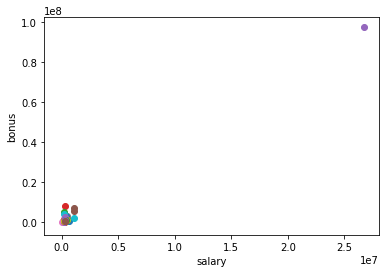

In [39]:
    
#   
# as an example, i plotted the salary vs bonus 
#


for dic in data_dict.values():
    
   matplotlib.pyplot.scatter( dic['salary'] , dic['bonus']  )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()



#### next i will calculate the salaries outlier, i will assume that the highest 2.5% percent are the outliers.

In [7]:
# the plot shows a huge outlier, but lets check out the outler for the salary field

outliers = df.quantile(.975) 
print 'the salaries outlier is :{}'.format(outliers[1])
        
print('\n') 

for k, v in data_dict.items():
    if v['salary'] != 'NaN' and v['salary'] > outliers[1]: print 'name : {}'.format(k),':: salary {}'.format(v['salary'])
print('\n')

outliers = df.quantile(.975) 
print 'the bonus outlier is :{}'.format(outliers[2])
print('\n') 
for k, v in data_dict.items():
    if v['bonus'] != 'NaN' and v['bonus'] > outliers[2]: print 'name : {}'.format(k),':: bonus {}'.format(v['bonus'])


the salaries outlier is :807247.625


name : LAY KENNETH L :: salary 1072321
name : SKILLING JEFFREY K :: salary 1111258
name : TOTAL :: salary 26704229
name : FREVERT MARK A :: salary 1060932


the bonus outlier is :5381249.375


name : LAVORATO JOHN J :: bonus 8000000
name : LAY KENNETH L :: bonus 7000000
name : SKILLING JEFFREY K :: bonus 5600000
name : TOTAL :: bonus 97343619


##### 'Kenneth Lee' , 'Jeffrey Skilling' and 'FREVERT MARK A'  are very well known persons from ENRON, so i shouldn't exclude them.
##### 'LAVORATO JOHN J' on the other hand isn't as famous as the others and as i read his bonus was more of a ''company way to retain its talents" .
##### the value 'TOTAL'  looks to be the outlier.

In [8]:
# remove the value total  
df = df.drop(['TOTAL','LAVORATO JOHN J'],0)


### Create new feature(s)
#### in this part i will create two featuers, both shows the recentage of the emails between this person and a POI.

In [9]:

df_OLD = df[features_list] ## Keep the original data frame with the old features

## new feature that shows the amount of fraction of mails sent to a poi
df['fraction_to_poi'] = df['from_this_person_to_poi']/df['from_messages']

## new feature that shows the amount of fraction of mails sent from a poi
df['fraction_from_poi']=df['from_poi_to_this_person'] / df['to_messages']

#clean all 'infinite' values which ,"division by zero"
df = df.replace('inf', 0)



### Question 2: What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it.

###### * in the project i used Feature Importance in Decision Tree algorithm to get the best featuers,GridSearchCV is used to achieve the best estimate of importances of each feature.
###### * i have created two new features ('fraction_to_poi','fraction_from_poi') to measure the communication between a person and a POI
### Feature Scaling
###### * for the feature selection desicion Tree algoritm i haven't done any scaling because Decision tree doesn't require me to do any feature scaling .
######  *since i'm going to try three classifiers, for  $Decision Tree$ and $Random Forest$ i havent done any scaling and used the features optained from Feature importnace in Decision Tree, for  $GaussianNB$ i have done standardized features scaling to have a normal distributed features.


### Seletcting  the features


### First , i will check the old features importance ( without the new features) 

In [11]:
Tclf = tree.DecisionTreeClassifier(random_state = 42)
Tclf.fit(df_OLD.ix[:,1:], df_OLD.ix[:,:1])

# show the features with non null importance, sorted and create features_list of features for the model
features_importance = []
for i in range(len(Tclf.feature_importances_)):
    if Tclf.feature_importances_[i] > 0:
        features_importance.append([df_OLD.columns[i+1], Tclf.feature_importances_[i]])
features_importance.sort(key=lambda x: x[1], reverse = True)
for f_i in features_importance:
    print f_i
#features_list = [x[0] for x in features_importance]
#features_list.insert(0, 'poi')
#

['from_poi_to_this_person', 0.23228479361669468]
['from_messages', 0.17138045074553013]
['from_this_person_to_poi', 0.1467315876672603]
['expenses', 0.12145089696110102]
['bonus', 0.095238095238095233]
['to_messages', 0.073881673881673909]
['long_term_incentive', 0.057142857142857162]
['shared_receipt_with_poi', 0.052910052910052914]
['total_payments', 0.048979591836734629]


### Next i the feature importance for all the features ( including the new ones )

In [13]:
clf = tree.DecisionTreeClassifier(random_state = 42)
clf.fit(df.ix[:,1:], df.ix[:,:1])

# show the features with non null importance, sorted and create features_list of features for the model
features_importance = []
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > 0:
        features_importance.append([df.columns[i+1], clf.feature_importances_[i]])
features_importance.sort(key=lambda x: x[1], reverse = True)
for f_i in features_importance:
    print f_i
features_list = [x[0] for x in features_importance]
features_list.insert(0, 'poi')
#

['fraction_to_poi', 0.34693877551020413]
['expenses', 0.31131267321743517]
['to_messages', 0.22010582010582005]
['total_payments', 0.070546737213403862]
['from_messages', 0.051095993953136812]


#### the result contains features with non-null feature importance, sorted by importance.
#### the importance of the features changed after adding the new features, the new feature ''fraction_to_poi' got the highest score.
#### the more features lead to overfitting the model, and less features leads to a bias model.

In [14]:
new_features_list=['poi','fraction_to_poi', 
'expenses', 
'to_messages',
'total_payments',
'from_messages' ]

new_dataset=df.to_dict(orient='index')
data = featureFormat(new_dataset, new_features_list)
labels, features = targetFeatureSplit(data)



### Question 3: What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?

###### i tried three classifires:
###### 1-  GaussianNB                        (Precision: 0.24144	Recall: 0.07050	)
###### 2-  RandomForestClassifier    (Precision: 0.61296	Recall: 0.37850 )
###### 3-  DecisionTreeClassifier       ( Precision: 0.61208	Recall: 0.63350 )
###  DecisionTreeClassifier has the best recall , and in our case the recall is more important since we want the algorithm to return all POI indivisual.

##  Classifier Selection



In [40]:
from tester import test_classifier, dump_classifier_and_data
from sklearn.preprocessing import StandardScaler
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html



# Provided to give you a starting point. Try a variety of classifiers.

   
#from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

#############################################################################
###  GaussianNB()                                                           #####
###### Accuracy: 0.84653	Precision: 0.24144	Recall: 0.07050	F1: 0.10913 ######
 #############################################################################
#data = featureFormat(new_dataset, features_list)
#labels, features = targetFeatureSplit(data)
#from sklearn.naive_bayes import GaussianNB

#from sklearn.cross_validation import train_test_split
#features_train, features_test, labels_train, labels_test = \
#   train_test_split(features, labels, test_size=0.3, random_state=42)


#scaler = StandardScaler()
#features = scaler.fit_transform(features)

#clf = GaussianNB()
#clf = clf.fit(features_train,labels_train)

#test_classifier(clf, new_dataset, features_list)



 #############################################################################
###  RandomForestClassifier                                                 #####
###### Accuracy: 0.88527	Precision: 0.61296	Recall: 0.37850	F1: 0.46801 #####
 #############################################################################
#clf=RandomForestClassifier()
#clf.fit(features_train, labels_train)
#pred=clf.predict(features_test)

 #############################################################################
###  DecisionTreeClassifier                                                 #####
###### Accuracy: 0.89760	Precision: 0.61208	Recall: 0.63350	F1: 0.62260 #####
 #############################################################################
#clf=tree.DecisionTreeClassifier()
#clf.fit(features_train, labels_train)
#pred=clf.predict(features_test)

#test_classifier(clf, new_dataset, features_list)
#tester.dump_classifier_and_data(clf, new_dataset, features_list)
#tester.main() 

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!


### Question 4: What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well? How did you tune the parameters of your particular algorithm?

#### Parameters tuning is an important step, the default behavior of the fanction might not be always efficient, adjustment of the algorithm when training improves the fit on the test set.
#### Parameter can influence the outcome of the learning process, the more tuned the parameters, the more biased the algorithm will be to the training data.
##### in DecisionTreeClassifier i used the following parameters : (max_features=5,min_samples_split=2,max_depth = 10,criterion='gini',random_state=42)

## Algorithm tuning



In [34]:





clf = tree.DecisionTreeClassifier(max_features=5,min_samples_split=2,
                                  max_depth = 10,criterion='gini',
                                  random_state=42)
                                  
           

#tester.dump_classifier_and_data(clf, new_dataset, features_list)
#tester.main() 

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

<pre>
```

| Parameters                             | score              |
|----------------------------------------|--------------------|
| max_features=2,min_samples_split=5,    | Precision: 0.65414 |
|  max_depth = 40,criterion='entropy',   |                    |
|    random_state=75                     | Recall:    0.60050 | 
|-------------------------------------------------------------|
| max_features=4,min_samples_split=2,    | Precision: 0.61693 |
|  ,max_depth = 10,criterion='gini',     |                    |
|    random_state=42                     | Recall:    0.67400 | 
|-------------------------------------------------------------|
| max_features=3,min_samples_split=10,   | Precision: 0.69540 |
|  ,max_depth = 50,criterion='entropy',  |                    |
|    random_state=72                     | Recall:    0.59700 | 
|-------------------------------------------------------------|




```
</pre>

### Next i will run the tuned algoritm with  train_test_split

In [31]:
from sklearn.cross_validation import train_test_split


features_train, features_test, labels_train, labels_test = \
   train_test_split(features, labels, test_size=0.3, random_state=42)

data = featureFormat(new_dataset, new_features_list)
labels, features = targetFeatureSplit(data)

clf = tree.DecisionTreeClassifier(max_features=2,min_samples_split=5,max_depth = 40,criterion='entropy',
                                 random_state=75)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

        ### fit the classifier using training set, and test on test set
clf.fit(features_train, labels_train)
predictions = clf.predict(features_test)
for prediction, truth in zip(predictions, labels_test):
    if prediction == 0 and truth == 0:
        true_negatives += 1
    elif prediction == 0 and truth == 1:
        false_negatives += 1
    elif prediction == 1 and truth == 0:
        false_positives += 1
    elif prediction == 1 and truth == 1:
        true_positives += 1
    else:
        print "Warning: Found a predicted label not == 0 or 1."
        print "All predictions should take value 0 or 1."
        print "Evaluating performance for processed predictions:"
        break;
total_predictions = true_negatives + false_negatives + false_positives + true_positives
accuracy = 1.0*(true_positives + true_negatives)/total_predictions
precision = 1.0*true_positives/(true_positives+false_positives)
recall = 1.0*true_positives/(true_positives+false_negatives)
print 'f1 =', 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
print 'f2 =', (1+2.0*2.0) * precision*recall/(4*precision + recall)
#print clf
#print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
print 'Accuracy =',accuracy,'Percision =', precision,'Recall =',recall

f1 = 0.363636363636
f2 = 0.285714285714
Accuracy = 0.840909090909 Percision = 0.666666666667 Recall = 0.25


<pre>
```

| Parameters                             | score              |
|----------------------------------------|--------------------|
| max_features=2,min_samples_split=5,    | Precision: 0.66667 |
|  max_depth = 40,criterion='entropy',   |                    |
|    random_state=75                     | Recall:    0.25000 | 
|-------------------------------------------------------------|
| max_features=4,min_samples_split=2,    | Precision: 0.50000 |
|  ,max_depth = 10,criterion='gini',     |                    |
|    random_state=42                     | Recall:    0.50000 | 
|-------------------------------------------------------------|
| max_features=3,min_samples_split=10,   | Precision: 0.50000 |
|  ,max_depth = 50,criterion='entropy',  |                    |
|    random_state=72                     | Recall:    0.25000 | 
|-------------------------------------------------------------|




```
</pre>


#### The results from StratifiedShuffleSplit were higher than using just train_test_split. This is because using stratified splits is more accurate than just splitting the data set.

### Question 5:What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?

#### Validation allows us to assess how well the chosen algorithm,overfitting is one of the biggest mistakes one can make is therefore to use the same data fro training and testing.
####  For validation I'm using provided tester function which performs stratified shuffle split cross validation approach using StratifiedShuffleSplit function from sklearn.cross_validation library.
#### Stratified selection is important because it reduces selection bias.Stratifying the entire population before applying random sampling methods helps ensure a sample that accurately reflects the population being studied 


In [35]:



### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

tester.dump_classifier_and_data(clf, new_dataset, features_list)
tester.main() 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
	Accuracy: 0.90073	Precision: 0.61693	Recall: 0.67400	F1: 0.64421	F2: 0.66176
	Total predictions: 15000	True positives: 1348	False positives:  837	False negatives:  652	True negatives: 12163



### Question 6:Give at least 2 evaluation metrics, and your average performance for each of them. Explain an interpretation of your metrics that says something human-understandable about your algorithm's performance
####  I used Percision & recall as 2 main evaluation metrics , the DecisionTreeClassifier provided the best recall score before tuning.
### Average scores of tuned classifier with stratified shuffle  :
#### the average Recall i got was :      0.6238
#### the average persicion score i got was :  0.65549
##### Relatively speaking, looking at the tuned model with a precision score of 0.61, it tells us that if this model predicts 100 POIs, then the chance would be 61 people who are truely POIs and the rest 39 are innocent. On the other hand, with a recall score of 0.67, this model can find 67% of all real POIs in prediction.The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0.

### References:

Enron Bonuses article : http://www.salon.com/2002/02/08/enron_bonuses/
    
F1 score on Wikipedia : https://en.wikipedia.org/wiki/F1_score

Advantages and Disadvantages of Stratified Random Sampling: http://www.investopedia.com/ask/answers/041615/what-are-advantages-and-disadvantages-stratified-random-sampling.asp#ixzz4jVOqGPan 